# Pathway patterns throughout the week in an example single stroke team

## Aims

Show key pathway statistics broken down by day of week in a single example team.

## Import libraries and data

Data has been resticted to stroke teams with at least 300 admissions, with at least 10 patients receiving thrombolysis, over three years.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Display entire dataframes
pd.set_option("display.max_rows", 999, "display.max_columns", 150)


# import data
raw_data = pd.read_csv(
    './../data/2019-11-04-HQIP303-Exeter_MA.csv', low_memory=False)

In [2]:
headings = list(raw_data)
print (headings)

['StrokeTeam', 'PatientUID', 'Pathway', 'S1AgeOnArrival', 'MoreEqual80y', 'S1Gender', 'S1Ethnicity', 'S1OnsetInHospital', 'S1OnsetToArrival_min', 'S1OnsetDateType', 'S1OnsetTimeType', 'S1ArriveByAmbulance', 'S1AdmissionHour', 'S1AdmissionDay', 'S1AdmissionQuarter', 'S1AdmissionYear', 'CongestiveHeartFailure', 'Hypertension', 'AtrialFibrillation', 'Diabetes', 'StrokeTIA', 'AFAntiplatelet', 'AFAnticoagulent', 'AFAnticoagulentVitK', 'AFAnticoagulentDOAC', 'AFAnticoagulentHeparin', 'S2INR', 'S2INRHigh', 'S2INRNK', 'S2NewAFDiagnosis', 'S2RankinBeforeStroke', 'Loc', 'LocQuestions', 'LocCommands', 'BestGaze', 'Visual', 'FacialPalsy', 'MotorArmLeft', 'MotorArmRight', 'MotorLegLeft', 'MotorLegRight', 'LimbAtaxia', 'Sensory', 'BestLanguage', 'Dysarthria', 'ExtinctionInattention', 'S2NihssArrival', 'S2BrainImagingTime_min', 'S2StrokeType', 'S2Thrombolysis', 'Haemorrhagic', 'TimeWindow', 'Comorbidity', 'Medication', 'Refusal', 'Age', 'Improving', 'TooMildSevere', 'TimeUnknownWakeUp', 'OtherMedical

## Restrict original data to hospitals with at least 300 admissions + 10 thrombolysis patients

In [3]:
keep = []

groups = raw_data.groupby('StrokeTeam') # creates a new object of groups of data

for index, group_df in groups: # each group has an index and a dataframe of data
    
    # Skip if total admissions less than 300 or total thrombolysis < 10
    admissions = group_df.shape[0]
    thrombolysis_received = group_df['S2Thrombolysis'] == 'Yes' 
    if (admissions < 300) or (thrombolysis_received.sum() < 10):
        continue
    
    else: 
        keep.append(group_df)

# Concatenate output
data = pd.DataFrame()
data = pd.concat(keep)

Remove in-hospital onset

In [4]:
mask = data['S1OnsetInHospital'] == 'No'
data = data[mask]

## Restrict to single stroke_team

In [5]:
team_pick = 0
teams = list(set(data['StrokeTeam']))
teams.sort()
team = teams[team_pick]
mask = data['StrokeTeam'] == team
selected_data = data[mask]
print (f'Arrivals {mask.sum()}')

Arrivals 2015


## Group by day of week

In [6]:
# Work on copy of data
data_time = selected_data.copy()

# Set up results DataFrame
day_summary = pd.DataFrame()

# Count arrivals
day_summary['Arrivals'] = \
    data_time.groupby('S1AdmissionDay').count()['StrokeTeam']

# Get thrombolysis rate
thrombolysed = data_time['S2Thrombolysis'] == 'Yes'
data_time['thrombolysed'] = thrombolysed
day_summary['thrombolyse_all'] = \
    data_time.groupby('S1AdmissionDay').mean()['thrombolysed']

# Get proportion of strokes with known onset
onset_known = (data_time['S1OnsetTimeType'] == 'Best estimate') | \
    (data_time['S1OnsetTimeType'] == 'Precise')
data_time['onset_known'] = onset_known
day_summary['onset_known'] = \
    data_time.groupby('S1AdmissionDay').mean()['onset_known']

# Get proportion over 80
data_time['age_80_plus'] = data_time['MoreEqual80y'] == 'Yes'
day_summary['age_80_plus'] = \
    data_time.groupby('S1AdmissionDay').mean()['age_80_plus']

# Get Rankin score
day_summary['rankin_all'] = \
    data_time.groupby('S1AdmissionDay').mean()['S2RankinBeforeStroke']

# Get NIHSS
day_summary['nihss_all'] = \
    data_time.groupby('S1AdmissionDay').mean()['S2NihssArrival']

# Get onset to arrival <4hrs and then restrict data
data_time['4hr_arrival'] = data_time['S1OnsetToArrival_min'] <= 240
day_summary['4hr_arrival'] = \
    data_time.groupby('S1AdmissionDay').mean()['4hr_arrival']
mask = data_time['4hr_arrival']
data_time = data_time[mask]

# Get Rankin score of arrivals within 4hrs onset
day_summary['rankin_4hr'] = \
    data_time.groupby('S1AdmissionDay').mean()['S2RankinBeforeStroke']

# Get NIHSS of arrivals within 4hrs onset
day_summary['nihss_4hr'] = \
    data_time.groupby('S1AdmissionDay').mean()['S2NihssArrival']

# Get onset to arrival (of those arriving within 4 hours)
day_summary['onset_arrival'] = \
    data_time.groupby('S1AdmissionDay').mean()['S1OnsetToArrival_min']

# Get scan in four hours (and remove rest)
data_time['4hr_scan'] = data_time['S2BrainImagingTime_min'] <= 240
day_summary['scan_4hrs'] = \
    data_time.groupby('S1AdmissionDay').mean()['4hr_scan']
mask = data_time['4hr_scan']
data_time = data_time[mask]

# Get arrival to scan (of those arriving within 4 hours and scanned in 4hrs)
day_summary['arrival_scan'] = \
    data_time.groupby('S1AdmissionDay').mean()['S2BrainImagingTime_min']

# Filter down to acanned within 4 hrs onset
onset_to_scan = (
    data_time['S1OnsetToArrival_min'] + data_time['S2BrainImagingTime_min'])
data_time['onset_to_scan'] = onset_to_scan
mask = data_time['onset_to_scan'] <= 240
data_time = data_time[mask]

# Get thrombolysis given and remove rest
day_summary['thrombolyse_4hr'] = \
    data_time.groupby('S1AdmissionDay').mean()['thrombolysed']
mask = data_time['thrombolysed']

# Get scan to needle
scan_to_needle = (
    data_time['S2ThrombolysisTime_min'] - data_time['S2BrainImagingTime_min'])
data_time['scan_needle'] = scan_to_needle
day_summary['scan_to_needle'] = \
    data_time.groupby('S1AdmissionDay').mean()['scan_needle']

# Get arrival to needle
day_summary['arrival_to_needle'] = \
    data_time.groupby('S1AdmissionDay').mean()['S2ThrombolysisTime_min']

# Get onset to needle 
onset_to_needle = (
    data_time['S1OnsetToArrival_min'] + data_time['S2ThrombolysisTime_min'])
data_time['onset_to_needle'] = onset_to_needle
day_summary['onset_to_needle'] = \
    data_time.groupby('S1AdmissionDay').mean()['onset_to_needle']

# Sort by day
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
            'Sunday']


day_summary = day_summary.loc[day_order]
day_summary['Weekday'] = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']

## Show summary table by day of week

In [7]:
day_summary

,Arrivals,thrombolyse_all,onset_known,age_80_plus,rankin_all,nihss_all,4hr_arrival,rankin_4hr,nihss_4hr,onset_arrival,scan_4hrs,arrival_scan,thrombolyse_4hr,scan_to_needle,arrival_to_needle,onset_to_needle,Weekday
S1AdmissionDay,,,,,,,,,,,,,,,,,
Monday,306,0.163399,0.620915,0.447712,1.052288,8.879310,0.388889,0.899160,10.412281,109.369748,0.966387,19.000000,0.449541,43.285714,53.326531,148.040816,Mo
Tuesday,277,0.173285,0.657040,0.425993,0.870036,9.337121,0.451264,0.800000,12.049587,106.520000,0.984000,20.609756,0.417391,42.916667,55.062500,147.104167,Tu
Wednesday,272,0.169118,0.621324,0.463235,1.198529,7.855469,0.455882,1.016129,9.264463,114.225806,0.943548,12.410256,0.394737,41.155556,47.488889,149.555556,We
Thursday,306,0.147059,0.633987,0.428105,1.111111,8.802768,0.408497,0.928000,10.785124,112.016000,0.976000,25.139344,0.403670,46.840909,55.272727,145.772727,Th
Friday,335,0.152239,0.608955,0.438806,1.035821,9.586319,0.438806,1.081633,10.791367,113.088435,0.979592,17.354167,0.360294,39.142857,46.530612,139.163265,Fr
Saturday,259,0.142857,0.648649,0.432432,0.918919,8.794979,0.432432,0.892857,9.271028,110.437500,0.982143,21.609091,0.377551,56.324324,64.783784,160.324324,Sa
Sunday,260,0.134615,0.665385,0.450000,0.934615,8.445833,0.461538,0.950000,10.324074,109.933333,0.925000,14.198198,0.317757,62.058824,68.441176,176.205882,Su


## Show summary charts of key metrics by day of week

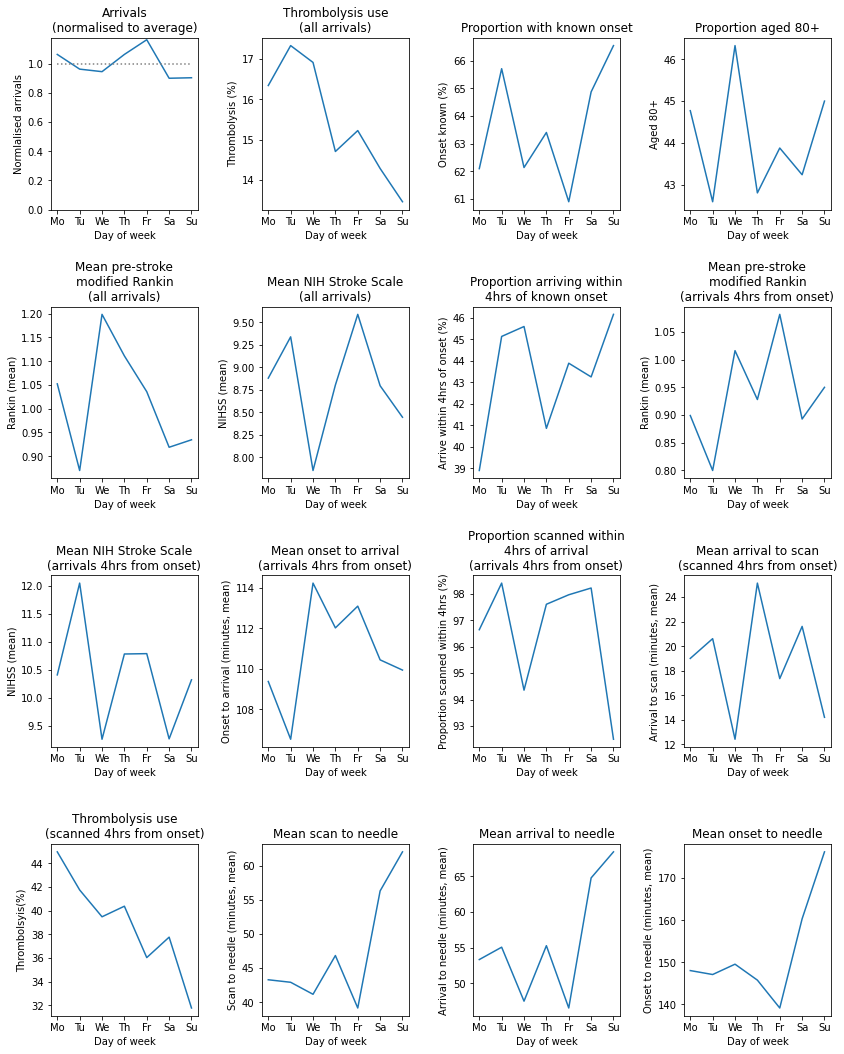

In [8]:
# Set up figure
fig = plt.figure(figsize=(12,15))

# Subplot 1: Arrivals
ax1 = fig.add_subplot(4,4,1)
x = day_summary['Weekday']
y = day_summary['Arrivals'] / day_summary['Arrivals'].sum() * 7
ax1.plot(x,y)
# Add line at 1
y1 = np.repeat(1,7)
ax1.plot(x,y1, color='0.5', linestyle=':')
ax1.set_ylim(ymin=0) # must be after plot method
ax1.set_xlabel('Day of week')
ax1.set_ylabel('Normlalised arrivals')
ax1.set_title('Arrivals\n(normalised to average)')

# Subplot 2: Thrombolysis
ax2 = fig.add_subplot(4,4,2)
x = day_summary['Weekday']
y = day_summary['thrombolyse_all'] * 100
ax2.plot(x,y)
ax2.set_xlabel('Day of week')
ax2.set_ylabel('Thrombolysis (%)')
ax2.set_title('Thrombolysis use\n(all arrivals)')

# Subplot 3: Known onset
ax3 = fig.add_subplot(4,4,3)
x = day_summary['Weekday']
y = day_summary['onset_known'] * 100
ax3.plot(x,y)
ax3.set_xlabel('Day of week')
ax3.set_ylabel('Onset known (%)')
ax3.set_title('Proportion with known onset')

# Subplot 4: age_80_plus 
ax4 = fig.add_subplot(4,4,4)
x = day_summary['Weekday']
y = day_summary['age_80_plus'] * 100
ax4.plot(x,y)
ax4.set_xlabel('Day of week')
ax4.set_ylabel('Aged 80+')
ax4.set_title('Proportion aged 80+')

# Subplot 5: Rankin (all arrivals)
ax5 = fig.add_subplot(4,4,5)
x = day_summary['Weekday']
y = day_summary['rankin_all'] 
ax5.plot(x,y)
ax5.set_xlabel('Day of week')
ax5.set_ylabel('Rankin (mean)')
ax5.set_title('Mean pre-stroke\nmodified Rankin\n(all arrivals)')

# Subplot 6: NIHSS (all arrivals)
ax6 = fig.add_subplot(4,4,6)
x = day_summary['Weekday']
y = day_summary['nihss_all'] 
ax6.plot(x,y)
ax6.set_xlabel('Day of week')
ax6.set_ylabel('NIHSS (mean)')
ax6.set_title('Mean NIH Stroke Scale\n(all arrivals)')

# Subplot 7: 4hr_arrival
ax7 = fig.add_subplot(4,4,7)
x = day_summary['Weekday']
y = day_summary['4hr_arrival'] * 100
ax7.plot(x,y)
ax7.set_xlabel('Day of week')
ax7.set_ylabel('Arrive within 4hrs of onset (%)')
ax7.set_title('Proportion arriving within\n4hrs of known onset')

# Subplot 8: Rankin (4hr arrivals)
ax8 = fig.add_subplot(4,4,8)
x = day_summary['Weekday']
y = day_summary['rankin_4hr'] 
ax8.plot(x,y)
ax8.set_xlabel('Day of week')
ax8.set_ylabel('Rankin (mean)')
ax8.set_title('Mean pre-stroke\nmodified Rankin\n(arrivals 4hrs from onset)')

# Subplot 9: NIHSS (4hr arrivals)
ax9 = fig.add_subplot(4,4,9)
x = day_summary['Weekday']
y = day_summary['nihss_4hr'] 
ax9.plot(x,y)
ax9.set_xlabel('Day of week')
ax9.set_ylabel('NIHSS (mean)')
ax9.set_title('Mean NIH Stroke Scale\n(arrivals 4hrs from onset)')

# Subplot 10: onset_arrival (4hr arrivals)
ax10 = fig.add_subplot(4,4,10)
x = day_summary['Weekday']
y = day_summary['onset_arrival'] 
ax10.plot(x,y)
ax10.set_xlabel('Day of week')
ax10.set_ylabel('Onset to arrival (minutes, mean)')
ax10.set_title('Mean onset to arrival\n(arrivals 4hrs from onset)')

# Subplot 11: scan_4hrs (4hr arrivals)
ax11 = fig.add_subplot(4,4,11)
x = day_summary['Weekday']
y = day_summary['scan_4hrs'] * 100
ax11.plot(x,y)
ax11.set_xlabel('Day of week')
ax11.set_ylabel('Proportion scanned within 4hrs (%)')
ax11.set_title('Proportion scanned within\n4hrs of arrival\n(arrivals 4hrs from onset)')

# Subplot 12: arrival_scan (4hr scan)
ax12 = fig.add_subplot(4,4,12)
x = day_summary['Weekday']
y = day_summary['arrival_scan'] 
ax12.plot(x,y)
ax12.set_xlabel('Day of week')
ax12.set_ylabel('Arrival to scan (minutes, mean)')
ax12.set_title('Mean arrival to scan\n(scanned 4hrs from onset)')

# Subplot 13: thrombolysis (4hr scan)
ax13 = fig.add_subplot(4,4,13)
x = day_summary['Weekday']
y = day_summary['thrombolyse_4hr']  * 100
ax13.plot(x,y)
ax13.set_xlabel('Day of week')
ax13.set_ylabel('Thrombolsyis(%)')
ax13.set_title('Thrombolysis use\n(scanned 4hrs from onset)')

# Subplot 14: scan_to_needle
ax14 = fig.add_subplot(4,4,14)
x = day_summary['Weekday']
y = day_summary['scan_to_needle'] 
ax14.plot(x,y)
ax14.set_xlabel('Day of week')
ax14.set_ylabel('Scan to needle (minutes, mean)')
ax14.set_title('Mean scan to needle')

# Subplot 15: arrival_to_needle
ax15 = fig.add_subplot(4,4,15)
x = day_summary['Weekday']
y = day_summary['arrival_to_needle'] 
ax15.plot(x,y)
ax15.set_xlabel('Day of week')
ax15.set_ylabel('Arrival to needle (minutes, mean)')
ax15.set_title('Mean arrival to needle')

# Subplot 16: onset_to_needle
ax16 = fig.add_subplot(4,4,16)
x = day_summary['Weekday']
y = day_summary['onset_to_needle'] 
ax16.plot(x,y)
ax16.set_xlabel('Day of week')
ax16.set_ylabel('Onset to needle (minutes, mean)')
ax16.set_title('Mean onset to needle')

# Save and show
plt.tight_layout(pad=2)
plt.savefig('output/stats_by_day_of_week_single_team.jpg', dpi=300)
plt.show();

## Observations

* Individual hospitals may show similarities and differences in diurnal patterns to national average.

* This hospital shows a marked reduction in use of thrombolysis at weekends, which is associated with a lower use of thrombolysis in those scanned within 4 hours and a significantly slower scan-to-needle times. These observations *may* suggest that this unit struggles maintaining the post-scan thrombolysis pathway at weekends.
